# Cumulative Cp Plot
This notebook shows how to use PyTecplot, Slice, Integration, and Layout files to compute longitutinal Cp. We also compute the cumulative Cp in the longitudinal direction and plot the results.

The first step is to import the necessary modules and create some convenience functions.

In [22]:
import tecplot as tp
from tecplot.constant import *
import numpy as np

def extract_x_slice(pos):
    zone = tp.data.extract.extract_slice(origin=(pos,0,0), normal=(1,0,0), source=SliceSource.SurfaceZones)
    return zone

def integrate(zone,var,direction=None):
    """
    zone - the zone to integrate
    var - the variable to integate
    direction - the spatial variable number along which to integrate.  Typically this
        would be 0,1,2 (dx,dy,dz) and should be used for linear zones.  If None, the 
        integration will be done in whichever plot type the frame happens to be 
        in - in 2D and 3D this will integrate with respect to the cell length and cell
        area respectively.
    """
    if direction:
        frame = tp.active_frame()
        orig_plot_type = frame.plot_type
        frame.plot_type = PlotType.XYLine
        plot = frame.plot()
        plot.delete_linemaps()
        lmap = plot.add_linemap()
        # Varible indexes are 0-based
        lmap.x_variable_index = direction # Y, this is to ensure the integration is done with respect to dy
        lmap.y_variable_index = 2 # Z, really this variable doesn't matter.
        lmap.zone = zone
        lmap.show = True
        plot.view.fit()
    
    zone_num = zone.index+1
    var_num = var.index+1
    tp.macro.execute_extended_command(command_processor_id='CFDAnalyzer4',
    command=f"Integrate [{zone_num}] VariableOption='Scalar' XOrigin=0 YOrigin=0 ZOrigin=0 ScalarVar={var_num} Absolute='F' ExcludeBlanked='F' XVariable=1 YVariable=2 ZVariable=3 IntegrateOver='Cells' IntegrateBy='Zones' PlotResults='F' PlotAs='Result' TimeMin=0 TimeMax=0")
    
    if direction:
        tp.active_frame().plot_type = orig_plot_type
    return float(tp.active_frame().aux_data["CFDA.INTEGRATION_TOTAL"])

## Load the raw data
First we load the raw data and display it to give a frame of reference

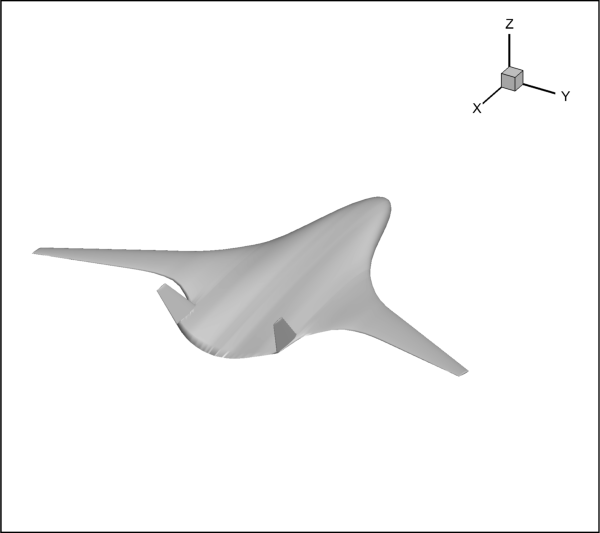

In [23]:
tp.new_layout()
ds = tp.data.load_tecplot("NASA_Blended_Wing.plt")
tp.active_frame().plot_type = PlotType.Cartesian3D
tp.extension.ipython.show()

## Use slices to compute longitudinal Cp
Now that the data are loaded, we determine min/max X-values for the data and extract slices at intervals in that range. We integrate Cp on each slice and retain the result in an array. We also compute the cumulative Cp.

In [24]:
results = list()
result_total = 0
var_to_integrate = ds.variable("Cp")
xmin,xmax = ds.variable(0).minmax()
for xpos in np.linspace(xmin, xmax, 50):
    zone = extract_x_slice(xpos)
    result = integrate(zone, var_to_integrate, direction=1)
    print(f"Extracted slice at: {xpos}; Integrated result: {result}")
    results.append((xpos,result))
    # Compute the area under the curve of Cp at each step to get
    # cumulative Cp values
    result_total = np.trapz([n[1] for n in results], [n[0] for n in results])
    results[-1] = (xpos, result, result_total)
    tp.active_frame().plot_type = PlotType.Cartesian3D

Extracted slice at: 0.0; Integrated result: -0.000169592000318729
Extracted slice at: 3.02856912244898; Integrated result: -0.702881175316764
Extracted slice at: 6.05713824489796; Integrated result: -0.239898393341656
Extracted slice at: 9.08570736734694; Integrated result: -0.661239577382095
Extracted slice at: 12.11427648979592; Integrated result: -1.63953781900768
Extracted slice at: 15.1428456122449; Integrated result: -1.80214434547689
Extracted slice at: 18.17141473469388; Integrated result: -1.97022544758337
Extracted slice at: 21.19998385714286; Integrated result: -1.46733682382753
Extracted slice at: 24.22855297959184; Integrated result: -0.607064856323644
Extracted slice at: 27.257122102040817; Integrated result: 0.33805929961474
Extracted slice at: 30.2856912244898; Integrated result: 1.57427303870397
Extracted slice at: 33.31426034693878; Integrated result: 2.54337215303587
Extracted slice at: 36.34282946938776; Integrated result: 3.02184585048057
Extracted slice at: 39.371

## Create a new zone with the result
Here we add a new zone and new variable to store the results that we captured above. Once the data are added to the dataset we save a Tecplot PLT file with the results for easy access later.

In [25]:
# Create a new line zone with the results
ds.add_variable("Cumulative Cp")
result_zone = ds.add_ordered_zone("Cp_Total_Results", (len(results),1,1), locations=[ValueLocation.Nodal]*ds.num_variables)
result_zone.values('X')[:] = [n[0] for n in results]
result_zone.values('Cp')[:] = [n[1] for n in results]
result_zone.values('Cumulative Cp')[:] = [n[2] for n in results]
tp.data.save_tecplot_plt("NASA_Blended_Wing_CpResult.plt", zones=[result_zone], variables=[ds.variable('X'), ds.variable('Cp'), ds.variable('Cumulative Cp')])

Dataset(uid=1174, frame=Frame(uid=1165, page=Page(uid=1156)))

## Compare the Cp integrated results
Here we're using Tecplot 360's integration as well as simple integration methods from numpy and scipy and comparing the results.

In [26]:
res = integrate(result_zone, var_to_integrate, direction=0)
print("Tecplot 360 result:", res)

res = np.trapz([n[1] for n in results], [n[0] for n in results])
print("Numpy result:      ", res)

from scipy.integrate import simps
res = simps([n[1] for n in results], [n[0] for n in results])
print("Scipy result:      ", res)

Tecplot 360 result: 3114.05798556713
Numpy result:       3114.058082608185
Scipy result:       3109.738944634349


## Create the final plot!
Since we have the original PLT file and the new PLT file we can skip writing a bunch of Python code to setup the plot style and simply use a layout file which references these two PLT files! 

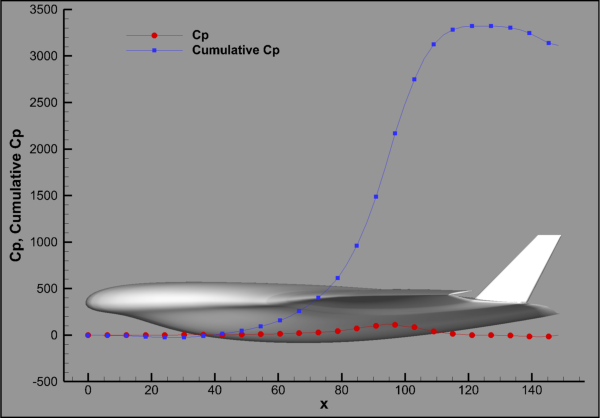

In [32]:
# Open a precreated layout that utilizes the data we just created.
tp.load_layout("NASA_Blended_Wing_CpResult.lay")
tp.extension.ipython.show()